In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Importing Required Libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split, sampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, models
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import xml.etree.ElementTree as ET

In [5]:
import torch
import torchvision
from tqdm import tqdm

In [6]:
def crop_image(breed, dog, data_dir):
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

(208, 277, 3)
(286, 185, 3)
(370, 291, 3)
(221, 316, 3)


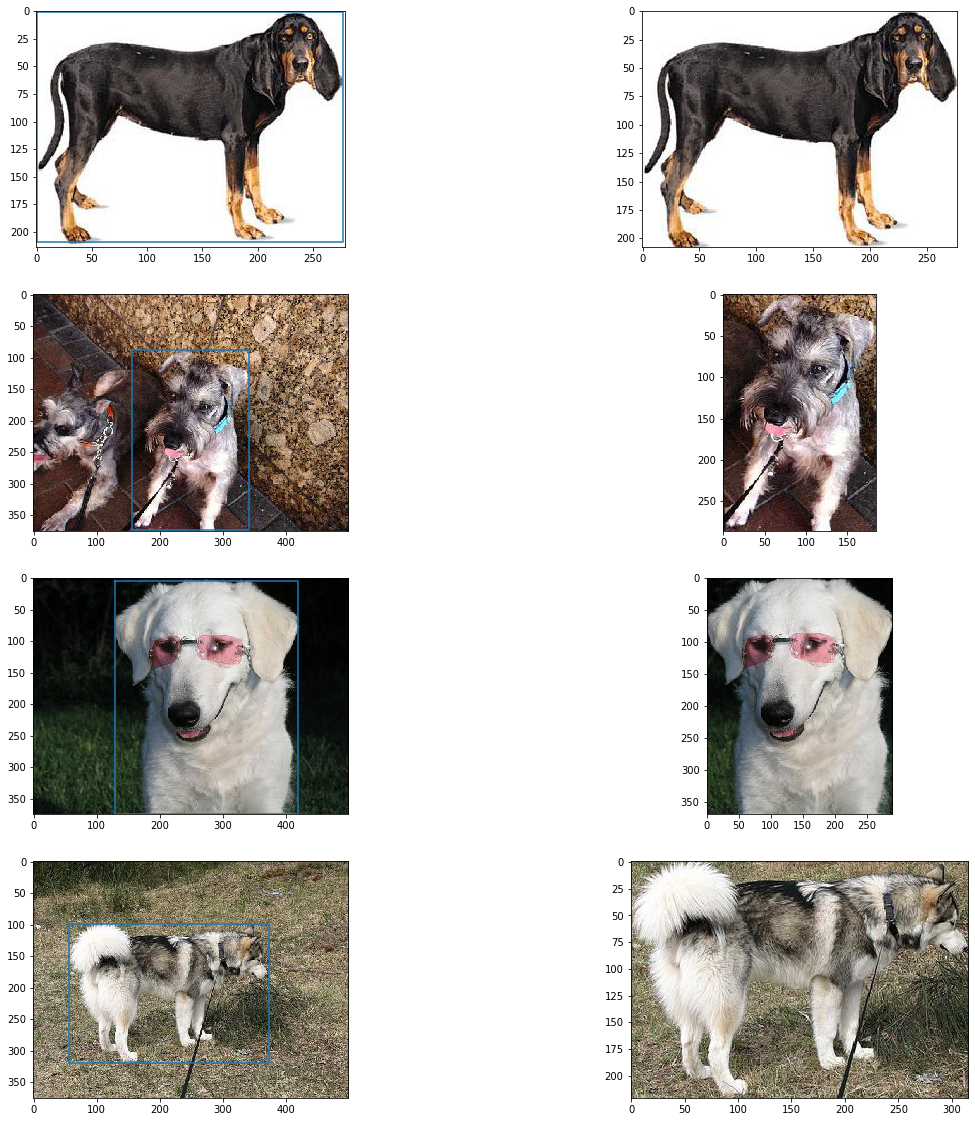

In [7]:
data_dir = 'stanford_dogs_dataset/'
breed_list = os.listdir(data_dir + 'images/Images/')

plt.figure(figsize=(20, 20))

for i in range(4):
    
    plt.subplot(421 + (i*2))
    
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(data_dir + 'annotations/Annotation/' + breed))
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    plt.imshow(img)
    
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    
    crop_img = crop_image(breed, dog, data_dir)
    print(crop_img.shape)
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

In [8]:
if 'cropped_data' not in os.listdir():
    
    os.mkdir('cropped_data')
    
    for breed in breed_list:
        os.mkdir('cropped_data/' + breed)
    
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('cropped_data'))))

Created 120 folders to store cropped images of the different breeds.


In [9]:
# for breed in tqdm(os.listdir('cropped_data')):
    
#     for file in os.listdir(data_dir + 'annotations/Annotation/' + breed):
        
#         img = Image.open(data_dir + 'images/Images/' + breed + '/' + file + '.jpg')
#         tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + file)
#         xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
#         xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
#         ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
#         ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
#         img = img.crop((xmin,ymin,xmax,ymax))
#         img = img.convert('RGB')
#         img.save('cropped_data/' + breed + '/' + file + '.jpg')

In [10]:
img_count = 0

for folder in os.listdir('cropped_data'):
    
    for _ in os.listdir('cropped_data/' + folder):    
        img_count += 1
    
print('No. of Images: {}'.format(img_count))

No. of Images: 20580


In [11]:
# Data Augmentation
batch_size = 128
image_size = 224

image_transforms = {
    
    'train':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
    ]),
    'val':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.CenterCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
}

In [12]:
all_data = datasets.ImageFolder(root='cropped_data')

In [13]:
all_data.classes

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [16]:
train_data_len = int(len(all_data) * 0.8)
valid_data_len = int((len(all_data) - train_data_len) / 2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['val']

print(len(train_data), len(val_data), len(test_data))

16464 2058 2058


In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Define Model BCNN
**We will use ResNet as the base architecture as suggested in the paper**

![title](notebook_images/BCNN.png)

In [18]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [19]:
resnet = models.resnet18()
resnet.load_state_dict(torch.load('imagenet_models/resnet18-5c106cde.pth'), strict=False)

# freezing parameters
for param in resnet.parameters():
    param.requires_grad = False

layers = list(models.resnet18().children())[:-2]
resnet = nn.Sequential(*layers).cuda()

In [20]:
resnet(torch.randn(1, 3, image_size, image_size).cuda()).shape

torch.Size([1, 512, 7, 7])

In [21]:
features = 512
fmap_size = 7

class BCNN(nn.Module):
    def __init__(self, fine_tune=False):
        super(BCNN, self).__init__()
        
        resnet = models.resnet18(pretrained=False)
        resnet.load_state_dict(torch.load('imagenet_models/resnet18-5c106cde.pth'))
        
        
        # freezing parameters
        if not fine_tune:
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            
            for param in resnet.parameters():
                param.requires_grad = True

        layers = list(resnet.children())[:-2]
        self.features = nn.Sequential(*layers).cuda()        

        self.fc = nn.Linear(features ** 2, 120)
        self.dropout = nn.Dropout(0.5)
        
        # Initialize the fc layers.
        nn.init.xavier_normal_(self.fc.weight.data)
        
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias.data, val=0)
        
    def forward(self, x):
        
        ## X: bs, 3, 256, 256
        ## N = bs
        N = x.size()[0]
        
        ## x : bs, 1024, 14, 14
        x = self.features(x)
        
        # bs, (1024 * 196) matmul (196 * 1024)
        x = x.view(N, features, fmap_size ** 2)
        
        x = self.dropout(x)
        # Batch matrix multiplication
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        x = x.view(N, features ** 2)
        x = torch.sqrt(x + 1e-5)
        x = F.normalize(x)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [22]:
model = BCNN().cuda()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [25]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader,
          val_loader, 
          save_location, 
          early_stop=3, 
          n_epochs=20, 
          print_every=1):

    #Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop starts here
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        
        ### batch control
        ii = 0
        
        for data, label in train_loader:
            
            ii += 1
            
            data, label = data.cuda(), label.cuda()
            output = model(data)
            
            loss = criterion(output, label)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            
            # Calculate accuracy by finding max log probability
            # first output gives the max value in the row(not what we want), second output gives index of the highest val
            _, pred = torch.max(output, dim=1)
            
            # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            correct_tensor = pred.eq(label.data.view_as(pred))
            
            #tensor must be float to calc average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')
        
        model.epochs += 1
        
        with torch.no_grad():
            
            model.eval()
            
            for data, label in val_loader:
                
                data, label = data.cuda(), label.cuda()
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)
                
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)
            
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                
                torch.save({
                    'state_dict': model.state_dict()
                    #'idx_to_class': model.idx_to_class
                }, save_location)
                
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                
                stop_count += 1
                
                # Below is the case where we handle the early stop case
                if stop_count >= early_stop:
                    
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history
    
    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [26]:
from torchsummary import summary
summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='dog_bcnn_resnet.pt',
    early_stop=3,
    n_epochs=50,
    print_every=1)

Epoch: 0	8.53% complete.
Epoch: 0	16.28% complete.
Epoch: 0	24.03% complete.
Epoch: 0	31.78% complete.
Epoch: 0	39.53% complete.
Epoch: 0	47.29% complete.
Epoch: 0	55.04% complete.
Epoch: 0	62.79% complete.
Epoch: 0	70.54% complete.
Epoch: 0	78.29% complete.
Epoch: 0	86.05% complete.
Epoch: 0	93.80% complete.

Epoch: 0 	Training Loss: 3.2778 	Validation Loss: 2.1504
		Training Accuracy: 42.08%	 Validation Accuracy: 63.65%
Epoch: 1	8.53% complete.
Epoch: 1	16.28% complete.
Epoch: 1	24.03% complete.
Epoch: 1	31.78% complete.
Epoch: 1	39.53% complete.
Epoch: 1	47.29% complete.
Epoch: 1	55.04% complete.
Epoch: 1	62.79% complete.
Epoch: 1	70.54% complete.
Epoch: 1	78.29% complete.
Epoch: 1	86.05% complete.
Epoch: 1	93.80% complete.

Epoch: 1 	Training Loss: 1.7413 	Validation Loss: 1.4801
		Training Accuracy: 69.74%	 Validation Accuracy: 69.34%
Epoch: 2	8.53% complete.
Epoch: 2	16.28% complete.
Epoch: 2	24.03% complete.
Epoch: 2	31.78% complete.
Epoch: 2	39.53% complete.
Epoch: 2	47.29% com

In [28]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,3.277793,2.150358,0.420797,0.636540
1,1.741279,1.480124,0.697400,0.693392
2,1.277717,1.232994,0.751761,0.727405
3,1.062260,1.107570,0.773081,0.736638
4,0.935353,1.025201,0.791970,0.752187
5,0.846365,0.975148,0.808066,0.755102
6,0.777842,0.955093,0.819181,0.749757
7,0.718638,0.923642,0.829507,0.758989
8,0.670577,0.904677,0.844813,0.757046
9,0.632336,0.883893,0.851494,0.758989


In [29]:
def test(model, test_loader, criterion):
    
    with torch.no_grad():
        model.eval()
        test_acc = 0
        
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [30]:
model.load_state_dict(torch.load('dog_bcnn_resnet.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 74.93% on the test dataset


In [31]:
model = BCNN(fine_tune=True).cuda()
model.load_state_dict(torch.load('dog_bcnn_resnet.pt')['state_dict'])

<All keys matched successfully>

In [32]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [33]:
summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [34]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='dog_bcnn_finetuned.pt',
    early_stop=3,
    n_epochs=50,
    print_every=1)

Epoch: 0	4.26% complete.
Epoch: 0	8.14% complete.
Epoch: 0	12.02% complete.
Epoch: 0	15.89% complete.
Epoch: 0	19.77% complete.
Epoch: 0	23.64% complete.
Epoch: 0	27.52% complete.
Epoch: 0	31.40% complete.
Epoch: 0	35.27% complete.
Epoch: 0	39.15% complete.
Epoch: 0	43.02% complete.
Epoch: 0	46.90% complete.
Epoch: 0	50.78% complete.
Epoch: 0	54.65% complete.
Epoch: 0	58.53% complete.
Epoch: 0	62.40% complete.
Epoch: 0	66.28% complete.
Epoch: 0	70.16% complete.
Epoch: 0	74.03% complete.
Epoch: 0	77.91% complete.
Epoch: 0	81.78% complete.
Epoch: 0	85.66% complete.
Epoch: 0	89.53% complete.
Epoch: 0	93.41% complete.
Epoch: 0	97.29% complete.

Epoch: 0 	Training Loss: 0.4585 	Validation Loss: 0.7810
		Training Accuracy: 87.06%	 Validation Accuracy: 77.75%
Epoch: 1	4.26% complete.
Epoch: 1	8.14% complete.
Epoch: 1	12.02% complete.
Epoch: 1	15.89% complete.
Epoch: 1	19.77% complete.
Epoch: 1	23.64% complete.
Epoch: 1	27.52% complete.
Epoch: 1	31.40% complete.
Epoch: 1	35.27% complete.
Epoch

In [35]:
model.load_state_dict(torch.load('dog_bcnn_finetuned.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 77.79% on the test dataset
